In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.tsa.seasonal import STL
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator, awesome_oscillator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
import warnings
warnings.filterwarnings('ignore')

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'


Bad key "text.kerning_factor" on line 4 in
C:\Users\Pranav\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def plot_ohlc(df):
    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Ohlc(x=df.index,
                          open=df.Open,
                          high=df.High,
                          low=df.Low,
                          close=df.Close,
                          name='Price'), row=1, col=1)

    fig.add_trace(go.Scatter(x=df.index, y=df.Volume, name='Volume'), row=2, col=1)

    fig.update(layout_xaxis_rangeslider_visible=False)
    fig.show()

def plot_decomposed_close_data(df):
    data = azn_df[['Close']].copy()
    res = STL(data, period=365).fit()
    fig = res.plot()
    fig.set_size_inches(20, 8)
    
def plot_moving_averages(df):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index, y=df.EMA_9, name='EMA 9'))
    fig.add_trace(go.Scatter(x=df.index, y=df.SMA_5, name='SMA 5'))
    fig.add_trace(go.Scatter(x=df.index, y=df.SMA_10, name='SMA 10'))
    fig.add_trace(go.Scatter(x=df.index, y=df.SMA_15, name='SMA 15'))
    fig.add_trace(go.Scatter(x=df.index, y=df.SMA_30, name='SMA 30'))
    fig.add_trace(go.Scatter(x=df.index, y=df.Close, name='Close', opacity=0.2))
    fig.show()
    
def plot_RSI(df):
    fig = go.Figure(go.Scatter(x=df.index, y=df.RSI, name='RSI'))
    fig.show()
    
def plot_MACD(df):
    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Scatter(x=df.index, y=df['MACD'], name='MACD'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=df['MACD Signal'], name='Signal line'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=df.Close, name='Close'), row=2, col=1)
    fig.show()
    
def plot_train_test_data(train_df, valid_df, test_df):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
    fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
    fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
    fig.show()
    
def plot_predictions(predicted_prices, df, column):
    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Scatter(x=df.index, y=df[column],
                             name='Truth',
                             marker_color='LightSkyBlue'), row=1, col=1)

    fig.add_trace(go.Scatter(x=predicted_prices.index,
                             y=predicted_prices[column],
                             name='Prediction',
                             marker_color='MediumPurple'), row=1, col=1)

    fig.show()
    
def plot_high_low_predictions(predicted_prices, df):
    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Scatter(x=df.index, y=df.High,
                             name='Truth',
                             marker_color='LightSkyBlue'), row=1, col=1)

    fig.add_trace(go.Scatter(x=predicted_prices.index,
                             y=predicted_prices.High,
                             name='Prediction',
                             marker_color='MediumPurple'), row=1, col=1)

    fig.show()
    
def get_moving_averages(df):
    df_sma = SMAIndicator(close=df['Close'], window=5)
    df['SMA_5'] = df_sma.sma_indicator()
    df_sma = SMAIndicator(close=df['Close'], window=10)
    df['SMA_10'] = df_sma.sma_indicator()
    df_sma = SMAIndicator(close=df['Close'], window=15)
    df['SMA_15'] = df_sma.sma_indicator()
    df_sma = SMAIndicator(close=df['Close'], window=30)
    df['SMA_30'] = df_sma.sma_indicator()
    df_ema = EMAIndicator(close=df['Close'], window=9)
    df['EMA_9'] = df_ema.ema_indicator()
    df.dropna(inplace=True)
    
def get_RSI(df):
    df_rsi = RSIIndicator(close=df['Close'], window=14)
    df['RSI'] = df_rsi.rsi()
    df.dropna(inplace=True)
    
def get_MACD(df):
    macd = MACD(close=df['Close'])
    df['MACD'] = macd.macd()
    df['MACD Signal'] = macd.macd_signal()
    df.dropna(inplace=True)

In [3]:
start = dt.datetime(2017,1,1)
end = dt.datetime.now()
tickers = ['PFE', 'MRNA', 'JNJ', 'AZN', 'BTC-USD']

filenames = []

for ticker in tickers:
    if ticker == 'MRNA':
        df = yf.download(ticker, dt.datetime(2018,12,7), end)
    else:
        df = yf.download(ticker, start, end)
    filename = f'{ticker}_stock_prices.csv'
    filenames.append(filename)
    df.to_csv(filename)
    
for filename in filenames:
    if filename.startswith('AZN'):
        azn_df = pd.read_csv('AZN_stock_prices.csv', index_col='Date', parse_dates=True)
    elif filename.startswith('BTC-USD'):
        btc_df = pd.read_csv('BTC-USD_stock_prices.csv', index_col='Date', parse_dates=True)    
    elif filename.startswith('MRNA'):
        mrna_df = pd.read_csv('MRNA_stock_prices.csv', index_col='Date', parse_dates=True)
    elif filename.startswith('JNJ'):
        jnj_df = pd.read_csv('JNJ_stock_prices.csv', index_col='Date', parse_dates=True)
    else:
        pfe_df = pd.read_csv('PFE_stock_prices.csv', index_col='Date', parse_dates=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
btc_df.head()

Open         High          Low        Close    Adj Close  \
Date                                                                          
2017-01-01   963.658020  1003.080017   958.698975   998.325012   998.325012   
2017-01-02   998.617004  1031.390015   996.702026  1021.750000  1021.750000   
2017-01-03  1021.599976  1044.079956  1021.599976  1043.839966  1043.839966   
2017-01-04  1044.400024  1159.420044  1044.400024  1154.729980  1154.729980   
2017-01-05  1156.729980  1191.099976   910.416992  1013.380005  1013.380005   

               Volume  
Date                   
2017-01-01  147775008  
2017-01-02  222184992  
2017-01-03  185168000  
2017-01-04  344945984  
2017-01-05  510199008

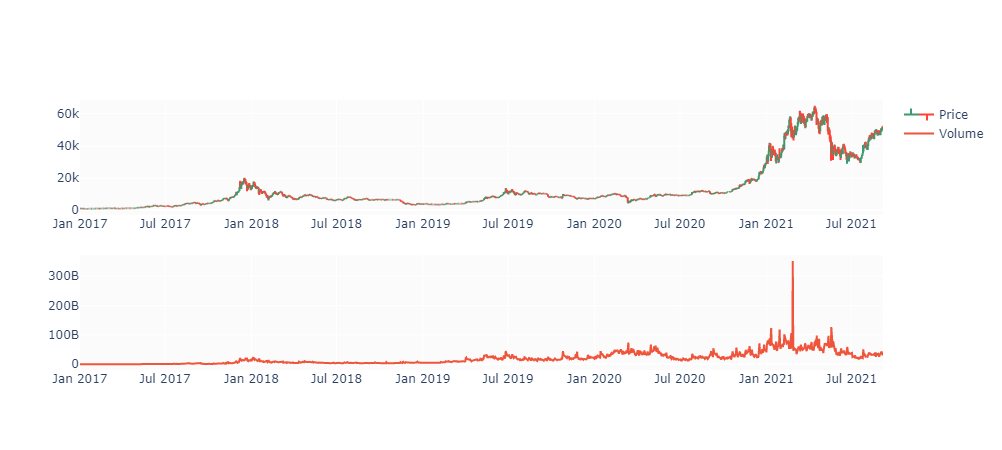

In [5]:
# Get OHLC chart for BTC

plot_ohlc(btc_df)

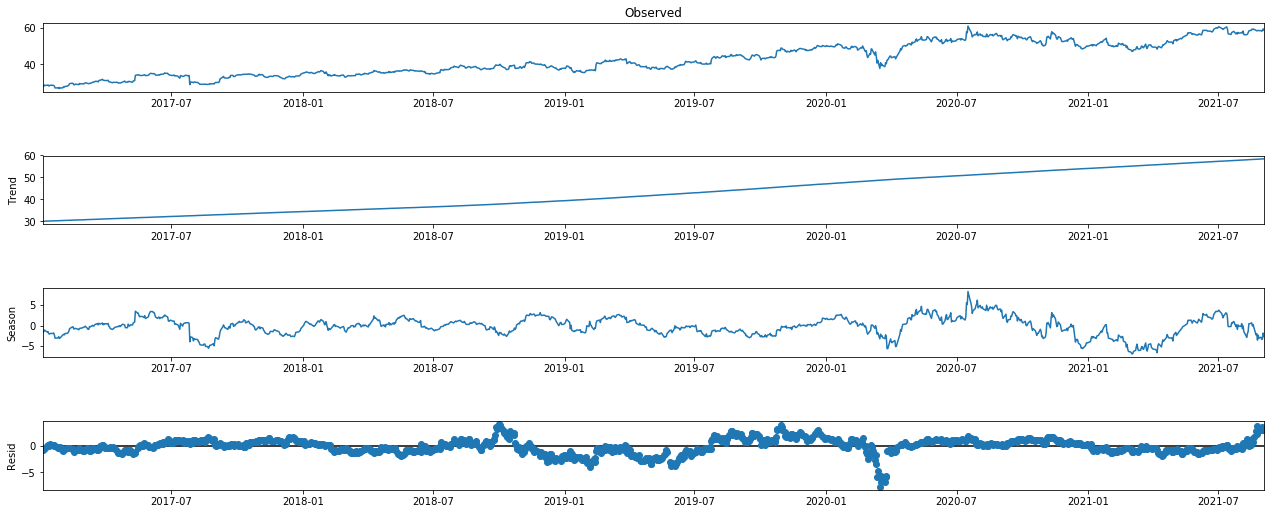

In [6]:
# Decomposing close price for BTC

plot_decomposed_close_data(btc_df)

In [7]:
get_moving_averages(btc_df)
btc_df.head()

Open         High          Low        Close    Adj Close  \
Date                                                                          
2017-01-30   920.151001   923.047974   919.473999   920.382019   920.382019   
2017-01-31   920.958984   972.018982   920.958984   970.403015   970.403015   
2017-02-01   970.940979   989.114014   970.742004   989.023010   989.023010   
2017-02-02   990.000977  1013.520020   983.221008  1011.799988  1011.799988   
2017-02-03  1011.460022  1033.869995  1008.789978  1029.910034  1029.910034   

               Volume       SMA_5      SMA_10      SMA_15      SMA_30  \
Date                                                                    
2017-01-30   78227296  919.760803  916.050702  905.379732  913.066597   
2017-01-31  164582000  930.324207  920.912103  914.637667  912.135864   
2017-02-01  150110000  944.178809  927.347107  920.043335  911.044965   
2017-02-02  145820992  962.220801  936.425903  928.388802  909.976965   
2017-02-03  201278000  984.303613  950.148206  937.111271  905.816300   

                 EMA_9  
Date                    
2017-01-30  913.125403  
2017-01-31  924.580925  
2017-02-01  937.469342  
2017-02-02  952.335471  
2017-02-03  967.850384

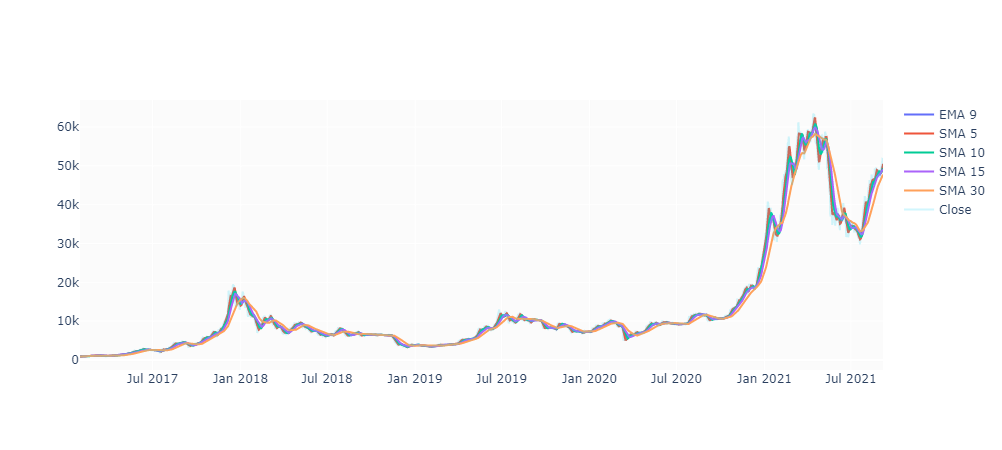

In [8]:
# Plotting Moving Averages for BTC

plot_moving_averages(btc_df)

In [9]:
get_RSI(btc_df)
btc_df.head()

Open         High          Low        Close    Adj Close  \
Date                                                                          
2017-02-12  1003.520020  1004.760010   996.921021   999.181030   999.181030   
2017-02-13   998.885010  1002.099976   976.002014   990.642029   990.642029   
2017-02-14   991.734985  1011.510010   986.471008  1004.549988  1004.549988   
2017-02-15  1006.210022  1008.840027  1001.580017  1007.479980  1007.479980   
2017-02-16  1007.650024  1033.369995  1007.650024  1027.439941  1027.439941   

               Volume        SMA_5       SMA_10       SMA_15      SMA_30  \
Date                                                                       
2017-02-12   67530000  1009.951599  1024.940802  1004.034135  948.051333   
2017-02-13  100607000   995.466016  1021.014001  1008.777205  953.792334   
2017-02-14  137946000   997.499414  1017.178998  1014.388403  959.884068   
2017-02-15   89759400  1001.260608  1015.192999  1016.860201  965.748934   
2017-02-16  122277000  1005.858594  1014.121991  1019.421330  969.732332   

                  EMA_9        RSI  
Date                                
2017-02-12  1007.981941  56.064533  
2017-02-13  1004.513959  53.178586  
2017-02-14  1004.521164  57.056011  
2017-02-15  1005.112928  57.847975  
2017-02-16  1009.578330  62.871291

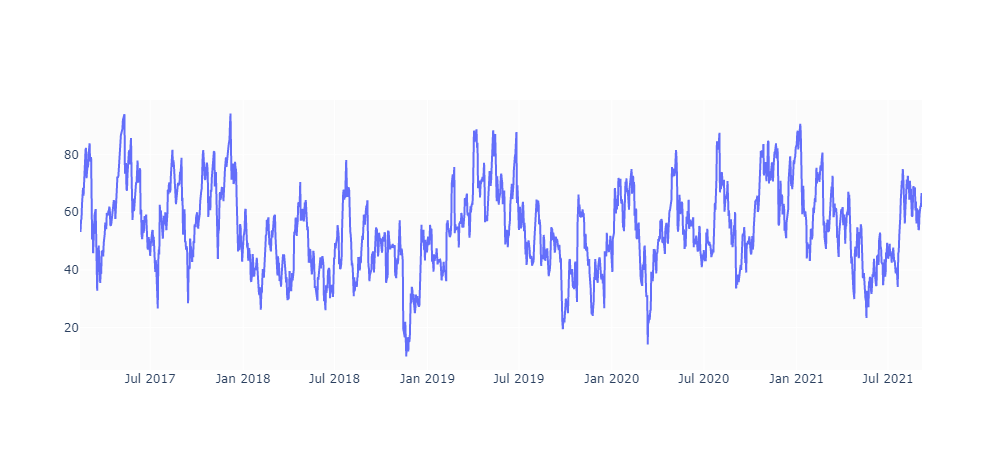

In [10]:
# Plotting RSI 

plot_RSI(btc_df)

In [11]:
get_MACD(btc_df)
btc_df.head()

Open         High          Low        Close    Adj Close  \
Date                                                                          
2017-03-17  1180.160034  1180.160034  1099.569946  1100.229980  1100.229980   
2017-03-18  1099.689941  1114.069946   957.655029   973.817993   973.817993   
2017-03-19   976.729980  1069.910034   976.729980  1036.739990  1036.739990   
2017-03-20  1037.239990  1063.030029  1036.680054  1054.229980  1054.229980   
2017-03-21  1055.359985  1122.430054  1055.359985  1120.540039  1120.540039   

               Volume        SMA_5       SMA_10       SMA_15       SMA_30  \
Date                                                                        
2017-03-17  706598976  1201.914014  1186.198999  1210.374666  1170.905660   
2017-03-18  621302016  1150.293604  1168.580798  1190.296533  1169.118262   
2017-03-19  406648000  1109.641602  1153.405798  1175.735864  1168.802596   
2017-03-20  286529984  1070.565601  1147.156799  1161.543197  1168.796261   
2017-03-21  337391008  1057.111597  1141.627808  1151.390535  1171.218595   

                  EMA_9        RSI       MACD  MACD Signal  
Date                                                        
2017-03-17  1189.225451  42.284127  19.974479    32.786728  
2017-03-18  1146.143959  32.793024   1.147403    26.458863  
2017-03-19  1124.263165  40.010917  -8.596813    19.447728  
2017-03-20  1110.256528  41.879437 -14.737987    12.610585  
2017-03-21  1112.313231  48.436942 -14.091803     7.270107

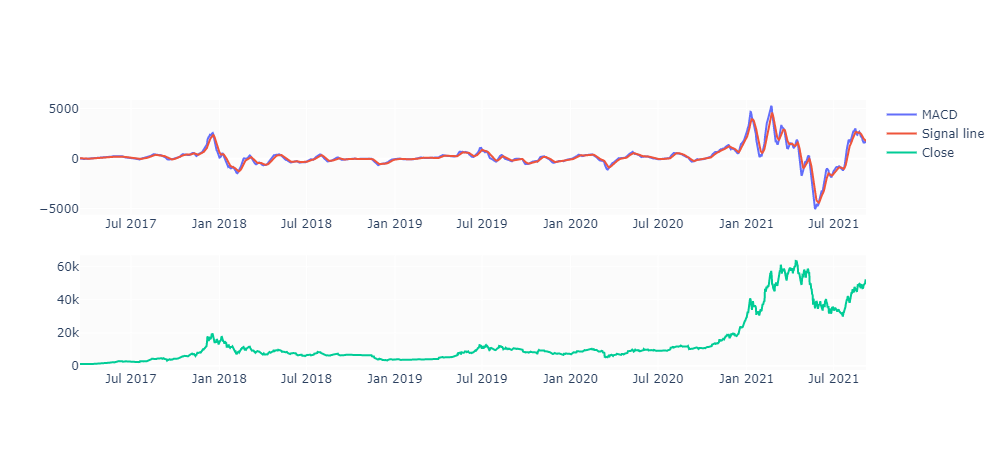

In [12]:
# Plottig MACD

plot_MACD(btc_df)

In [13]:
btc_df['Close'] = btc_df['Close'].shift(-1)
btc_df.head()

Open         High          Low        Close    Adj Close  \
Date                                                                          
2017-03-17  1180.160034  1180.160034  1099.569946   973.817993  1100.229980   
2017-03-18  1099.689941  1114.069946   957.655029  1036.739990   973.817993   
2017-03-19   976.729980  1069.910034   976.729980  1054.229980  1036.739990   
2017-03-20  1037.239990  1063.030029  1036.680054  1120.540039  1054.229980   
2017-03-21  1055.359985  1122.430054  1055.359985  1049.140015  1120.540039   

               Volume        SMA_5       SMA_10       SMA_15       SMA_30  \
Date                                                                        
2017-03-17  706598976  1201.914014  1186.198999  1210.374666  1170.905660   
2017-03-18  621302016  1150.293604  1168.580798  1190.296533  1169.118262   
2017-03-19  406648000  1109.641602  1153.405798  1175.735864  1168.802596   
2017-03-20  286529984  1070.565601  1147.156799  1161.543197  1168.796261   
2017-03-21  337391008  1057.111597  1141.627808  1151.390535  1171.218595   

                  EMA_9        RSI       MACD  MACD Signal  
Date                                                        
2017-03-17  1189.225451  42.284127  19.974479    32.786728  
2017-03-18  1146.143959  32.793024   1.147403    26.458863  
2017-03-19  1124.263165  40.010917  -8.596813    19.447728  
2017-03-20  1110.256528  41.879437 -14.737987    12.610585  
2017-03-21  1112.313231  48.436942 -14.091803     7.270107

In [14]:
btc_df = btc_df[:-1]
btc_df.tail()

Open          High           Low         Close  \
Date                                                                 
2021-09-01  47099.773438  49111.089844  46562.437500  49327.722656   
2021-09-02  48807.847656  50343.421875  48652.320312  50025.375000   
2021-09-03  49288.250000  50982.273438  48386.085938  49944.625000   
2021-09-04  50009.324219  50545.582031  49548.781250  51753.410156   
2021-09-05  49937.859375  51868.679688  49538.597656  51681.347656   

               Adj Close       Volume         SMA_5        SMA_10  \
Date                                                                
2021-09-01  48847.027344  39139399125  48160.186719  48301.487500   
2021-09-02  49327.722656  39508070319  48245.250781  48279.644922   
2021-09-03  50025.375000  43206179619  48484.359375  48511.570703   
2021-09-04  49944.625000  37471327794  49062.287500  48609.954297   
2021-09-05  51753.410156  30322676319  49979.632031  49091.073438   

                  SMA_15        SMA_30         EMA_9        RSI         MACD  \
Date                                                                           
2021-09-01  48139.997396  46221.663021  48088.630195  59.075752  1603.035676   
2021-09-02  48441.766406  46594.154427  48336.448687  60.377833  1596.058964   
2021-09-03  48662.286198  46936.750130  48674.233950  62.254867  1628.057351   
2021-09-04  48702.649479  47239.252474  48928.312160  61.889408  1628.132358   
2021-09-05  48892.510677  47537.149479  49493.331759  66.616806  1753.927462   

            MACD Signal  
Date                     
2021-09-01  2001.678910  
2021-09-02  1920.554921  
2021-09-03  1862.055407  
2021-09-04  1815.270797  
2021-09-05  1803.002130

In [15]:
btc_df.head()

Open         High          Low        Close    Adj Close  \
Date                                                                          
2017-03-17  1180.160034  1180.160034  1099.569946   973.817993  1100.229980   
2017-03-18  1099.689941  1114.069946   957.655029  1036.739990   973.817993   
2017-03-19   976.729980  1069.910034   976.729980  1054.229980  1036.739990   
2017-03-20  1037.239990  1063.030029  1036.680054  1120.540039  1054.229980   
2017-03-21  1055.359985  1122.430054  1055.359985  1049.140015  1120.540039   

               Volume        SMA_5       SMA_10       SMA_15       SMA_30  \
Date                                                                        
2017-03-17  706598976  1201.914014  1186.198999  1210.374666  1170.905660   
2017-03-18  621302016  1150.293604  1168.580798  1190.296533  1169.118262   
2017-03-19  406648000  1109.641602  1153.405798  1175.735864  1168.802596   
2017-03-20  286529984  1070.565601  1147.156799  1161.543197  1168.796261   
2017-03-21  337391008  1057.111597  1141.627808  1151.390535  1171.218595   

                  EMA_9        RSI       MACD  MACD Signal  
Date                                                        
2017-03-17  1189.225451  42.284127  19.974479    32.786728  
2017-03-18  1146.143959  32.793024   1.147403    26.458863  
2017-03-19  1124.263165  40.010917  -8.596813    19.447728  
2017-03-20  1110.256528  41.879437 -14.737987    12.610585  
2017-03-21  1112.313231  48.436942 -14.091803     7.270107

In [16]:
df_train_2019 = btc_df.loc['2017-01-01':'2018-12-31', :]
df_train_2019.head()

Open         High          Low        Close    Adj Close  \
Date                                                                          
2017-03-17  1180.160034  1180.160034  1099.569946   973.817993  1100.229980   
2017-03-18  1099.689941  1114.069946   957.655029  1036.739990   973.817993   
2017-03-19   976.729980  1069.910034   976.729980  1054.229980  1036.739990   
2017-03-20  1037.239990  1063.030029  1036.680054  1120.540039  1054.229980   
2017-03-21  1055.359985  1122.430054  1055.359985  1049.140015  1120.540039   

               Volume        SMA_5       SMA_10       SMA_15       SMA_30  \
Date                                                                        
2017-03-17  706598976  1201.914014  1186.198999  1210.374666  1170.905660   
2017-03-18  621302016  1150.293604  1168.580798  1190.296533  1169.118262   
2017-03-19  406648000  1109.641602  1153.405798  1175.735864  1168.802596   
2017-03-20  286529984  1070.565601  1147.156799  1161.543197  1168.796261   
2017-03-21  337391008  1057.111597  1141.627808  1151.390535  1171.218595   

                  EMA_9        RSI       MACD  MACD Signal  
Date                                                        
2017-03-17  1189.225451  42.284127  19.974479    32.786728  
2017-03-18  1146.143959  32.793024   1.147403    26.458863  
2017-03-19  1124.263165  40.010917  -8.596813    19.447728  
2017-03-20  1110.256528  41.879437 -14.737987    12.610585  
2017-03-21  1112.313231  48.436942 -14.091803     7.270107

In [17]:
df_train_2019.shape

(655, 14)

In [18]:
df_test_2019 = btc_df.loc['2019-01-01':'2019-12-31', :]
df_test_2019.shape

(365, 14)

In [19]:
x_train = df_train_2019.drop('Close', axis=1)
y_train = df_train_2019[['Close']]
x_test = df_test_2019.drop('Close', axis=1)
y_test = df_test_2019[['Close']]

In [20]:
# Preprocessing

scaler = MinMaxScaler()

scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [21]:
### Trying LSTM model

x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

model_1 = Sequential()

number_units = 50
dropout_fraction = 0.1

# Layer 1
model_1.add(LSTM(
    units = number_units,
    return_sequences = True,
    input_shape = (x_train.shape[1],1))
         )
model_1.add(Dropout(dropout_fraction))

# Layer 2
model_1.add(LSTM(
    units = number_units,
    return_sequences = True,
        ))
model_1.add(Dropout(dropout_fraction))

# Layer 3
model_1.add(LSTM(
    units = number_units,
    return_sequences = False,
        ))
model_1.add(Dropout(dropout_fraction))

model_1.add(Dense(1))

In [22]:
model_1.compile(optimizer="adam", loss="mean_squared_error")
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 13, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 13, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 13, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

In [23]:
epochs = 50
batch_size = 10
model_1.fit(x_train, y_train, epochs=epochs, shuffle=False, batch_size=batch_size, verbose=1)

Epoch 1/50
66/66 [==============================] - 3s 7ms/step - loss: 0.0053
Epoch 2/50
66/66 [==============================] - 0s 6ms/step - loss: 0.0174
Epoch 3/50
66/66 [==============================] - 0s 6ms/step - loss: 0.0286
Epoch 4/50
66/66 [==============================] - 0s 6ms/step - loss: 0.0201
Epoch 5/50
66/66 [==============================] - 0s 6ms/step - loss: 0.0163
Epoch 6/50
66/66 [==============================] - 0s 6ms/step - loss: 0.0106
Epoch 7/50
66/66 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 8/50
66/66 [==============================] - 0s 6ms/step - loss: 0.0034
Epoch 9/50
66/66 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 10/50
66/66 [==============================] - 0s 6ms/step - loss: 0.0027
Epoch 11/50
66/66 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 12/50
66/66 [==============================] - 0s 6ms/step - loss: 0.0034
Epoch 13/50
66/66 [==============================

In [24]:
model_1.evaluate(x_test, y_test)

12/12 [==============================] - 1s 3ms/step - loss: 0.0039


0.003864323953166604

In [25]:
y_pred = model_1.predict(x_test)
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 0.0038643236669989277


In [26]:
df_test_2019.shape

(365, 14)

In [27]:
df_test_2019['Predicted Close'] = scaler.inverse_transform(y_pred.reshape(-1,1))

In [28]:
df_test_2019.head()

Open         High          Low        Close    Adj Close  \
Date                                                                          
2019-01-01  3746.713379  3850.913818  3707.231201  3943.409424  3843.520020   
2019-01-02  3849.216309  3947.981201  3817.409424  3836.741211  3943.409424   
2019-01-03  3931.048584  3935.685059  3826.222900  3857.717529  3836.741211   
2019-01-04  3832.040039  3865.934570  3783.853760  3845.194580  3857.717529   
2019-01-05  3851.973877  3904.903076  3836.900146  4076.632568  3845.194580   

                Volume        SMA_5       SMA_10       SMA_15       SMA_30  \
Date                                                                         
2019-01-01  4324200990  3839.300098  3860.170166  3872.591943  3691.036963   
2019-01-02  5244856836  3843.198242  3854.613086  3889.081966  3692.679582   
2019-01-03  4530215219  3846.464746  3830.427295  3895.134668  3688.674495   
2019-01-04  4847965467  3844.817725  3834.649976  3876.686410  3692.131917   
2019-01-05  5137609824  3865.316553  3833.439673  3873.263135  3702.935010   

                  EMA_9        RSI       MACD  MACD Signal  Predicted Close  
Date                                                                         
2019-01-01  3825.324221  48.864036 -54.957248   -96.338158      4722.369141  
2019-01-02  3848.941261  51.568326 -40.902726   -85.251071      4858.322754  
2019-01-03  3846.501251  48.611883 -37.934365   -75.787730      4752.824219  
2019-01-04  3848.744507  49.228318 -33.503102   -67.330805      4781.270020  
2019-01-05  3848.034521  48.851558 -30.648494   -59.994342      4792.332520

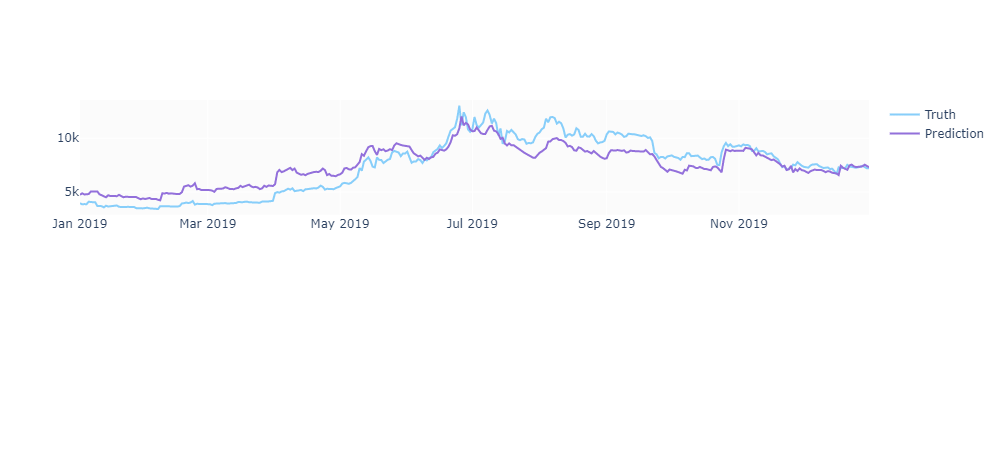

In [29]:
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df_test_2019.index, y=df_test_2019['Close'],
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=df_test_2019.index,
                         y=df_test_2019['Predicted Close'],
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.show()

#################

In [30]:
df_train_2021 = btc_df.loc['2019-01-01':'2020-12-31', :]
df_train_2021.tail()

Open          High           Low         Close  \
Date                                                                 
2020-12-27  26439.373047  28288.839844  25922.769531  27084.808594   
2020-12-28  26280.822266  27389.111328  26207.640625  27362.437500   
2020-12-29  27081.810547  27370.720703  25987.298828  28840.953125   
2020-12-30  27360.089844  28937.740234  27360.089844  29001.720703   
2020-12-31  28841.574219  29244.876953  28201.992188  29374.152344   

               Adj Close       Volume         SMA_5        SMA_10  \
Date                                                                
2020-12-27  26272.294922  66479895605  24870.283594  24142.261719   
2020-12-28  27084.808594  49056742893  25638.976172  24536.946484   
2020-12-29  27362.437500  45265946774  26364.273828  24886.207031   
2020-12-30  28840.953125  51287442704  27199.506250  25422.572852   
2020-12-31  29001.720703  46754964848  27712.442969  26042.436719   

                  SMA_15        SMA_30         EMA_9        RSI         MACD  \
Date                                                                           
2020-12-27  22889.632031  20823.602148  24294.084180  76.670934  1912.598775   
2020-12-28  23419.127083  21135.848633  24852.229063  78.691073  2039.260227   
2020-12-29  23960.179948  21442.013737  25354.270750  79.349097  2137.404010   
2020-12-30  24588.438411  21749.184310  26051.607225  82.456164  2307.883673   
2020-12-31  25101.179948  22089.141732  26641.629921  82.759909  2427.974456   

            MACD Signal  
Date                     
2020-12-27  1554.178256  
2020-12-28  1651.194650  
2020-12-29  1748.436522  
2020-12-30  1860.325952  
2020-12-31  1973.855653

In [31]:
df_test_2021 = btc_df.loc['2021-01-01':'2021-09-06', :]
df_test_2021.head()

Open          High           Low         Close  \
Date                                                                 
2021-01-01  28994.009766  29600.626953  28803.585938  32127.267578   
2021-01-02  29376.455078  33155.117188  29091.181641  32782.023438   
2021-01-03  32129.408203  34608.558594  32052.316406  31971.914062   
2021-01-04  32810.949219  33440.218750  28722.755859  33992.429688   
2021-01-05  31977.041016  34437.589844  30221.187500  36824.363281   

               Adj Close       Volume         SMA_5        SMA_10  \
Date                                                                
2021-01-01  29374.152344  40730301359  28332.814453  26601.549023   
2021-01-02  32127.267578  67865420765  29341.306250  27490.141211   
2021-01-03  32782.023438  78665235202  30425.223438  28394.748633   
2021-01-04  31971.914062  81163475344  31051.415625  29125.460938   
2021-01-05  33992.429688  67547324782  32049.557422  29881.000195   

                  SMA_15        SMA_30         EMA_9        RSI         MACD  \
Date                                                                           
2021-01-01  25539.112630  22428.243750  27188.134405  83.473733  2524.103099   
2021-01-02  26138.399740  22850.972721  28175.961040  87.570690  2790.274582   
2021-01-03  26732.545833  23320.381315  29097.173519  88.312749  3019.246730   
2021-01-04  27298.853776  23747.637435  29672.121628  81.805144  3099.609383   
2021-01-05  28044.810286  24235.881055  30536.183240  84.811358  3288.429125   

            MACD Signal  
Date                     
2021-01-01  2083.905142  
2021-01-02  2225.179030  
2021-01-03  2383.992570  
2021-01-04  2527.115933  
2021-01-05  2679.378571

In [32]:
x_train = df_train_2021.drop('Close', axis=1)
y_train = df_train_2021[['Close']]
x_test = df_test_2021.drop('Close', axis=1)
y_test = df_test_2021[['Close']]

In [33]:
# Preprocessing

scaler = MinMaxScaler()

scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [34]:
x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [35]:
epochs = 50
batch_size = 10
model_1.fit(x_train, y_train, epochs=epochs, shuffle=False, batch_size=batch_size, verbose=1)

Epoch 1/50
73/73 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 2/50
73/73 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 3/50
73/73 [==============================] - 0s 6ms/step - loss: 0.0048
Epoch 4/50
73/73 [==============================] - 0s 6ms/step - loss: 0.0030
Epoch 5/50
73/73 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 6/50
73/73 [==============================] - 0s 7ms/step - loss: 0.0014
Epoch 7/50
73/73 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 8/50
73/73 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 9/50
73/73 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 10/50
73/73 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 11/50
73/73 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 12/50
73/73 [==============================] - 0s 6ms/step - loss: 8.5437e-04
Epoch 13/50
73/73 [==========================

In [36]:
model_1.evaluate(x_test, y_test)

8/8 [==============================] - 0s 3ms/step - loss: 0.1922


0.1922132819890976

In [37]:
y_pred = model_1.predict(x_test)
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 0.192213276601797


In [38]:
df_test_2021['Predicted Close'] = scaler.inverse_transform(y_pred.reshape(-1,1))

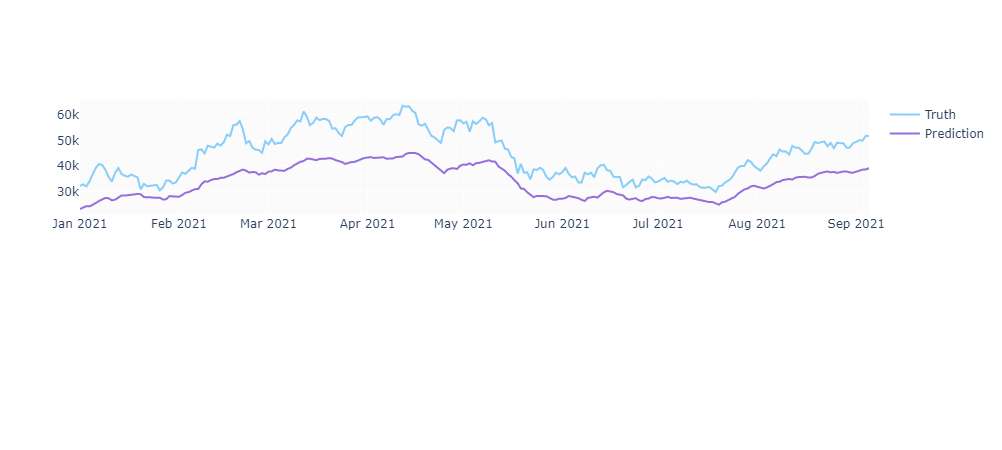

In [39]:
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df_test_2021.index, y=df_test_2021['Close'],
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=df_test_2021.index,
                         y=df_test_2021['Predicted Close'],
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.show()

In [40]:
df = pd.read_csv('BTC-USD_stock_prices.csv', index_col='Date', parse_dates=True)
get_moving_averages(df)
get_RSI(df)
get_MACD(df)
inp = df[-1:].drop('Close', axis=1)
inp

Open          High           Low     Adj Close  \
Date                                                                 
2021-09-06  51760.296875  51918.902344  51053.679688  51681.347656   

                 Volume         SMA_5        SMA_10        SMA_15  \
Date                                                                
2021-09-06  36409200640  50546.496094  49353.341406  49049.823698   

                  SMA_30         EMA_9        RSI         MACD  MACD Signal  
Date                                                                         
2021-09-06  47774.667708  49930.934939  66.264141  1826.748527  1807.751409

In [41]:
inp = np.array(inp)
inp = inp.reshape((inp.shape[0], inp.shape[1], 1))
tomorrow = model_1.predict(inp)
scaler.inverse_transform(tomorrow)

array([[25951.578]], dtype=float32)